In [74]:
# # Deep Learning with Python # #

# 6.8: Processing the labels of the raw data

import os
group1_dir = '/Users/sofia/comp150_project1/data/data1'
train_dir = os.path.join(group1_dir, 'train')
labels = []
texts = []
for label_type in ['female', 'male']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'male':
                labels.append(0)
            else:
                labels.append(1) 
                
print(texts[1])
print(len(texts))
print(len(texts[1])) # prints length in chracters --use nltk for words
print(labels[1])

No, nor I neither: I'll be at your elbow.
2050
41
1


In [75]:
# 6.9: Tokenizing the text of the raw data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# FIX: maxlen size is the size of the set of independent/explanatory variables inputed in the NN

maxlen = 50 # Cuts off reviews after maxlen words.
training_samples = 1000 # Trains on taining_samples. 
validation_samples = 1050 # Validates on validation_samples. 
max_words = 6745 # Considers only the most frequent words in the dataset 
                 # group 1 dataset only has 6745 tokens. 

tokenizer = Tokenizer(num_words=max_words)  
tokenizer.fit_on_texts(texts) 
sequences = tokenizer.texts_to_sequences(texts) 
print(len(sequences[1]), len(sequences[2])) # Sequences don't have the same length. There is one sequence per doc/speech.
                                            # How are sequences constructed? 
                                            # Tokenizer makes a dictionary of max_words size where the words are ranked by frequency. 
                                            # texts_to_sequences encodes each document/speech by replacing each word
                                            # in the order in which it occurs in the document with its rank number in the 
                                            # dictionary. 
                    
#one_hot_results = tokenizer.texts_to_matrix(texts, mode='binary')
#print(len(one_hot_results[1])) 

#print(sequences) # list of lists
                    
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
#print(word_index)

data = pad_sequences(sequences, maxlen=maxlen) 
print(data[1])

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices] # Splits the data into a training set and a validation set, but first shuffles the data, 
                         # because you’re starting with data in which samples are ordered (all negative first, 
                         # then all positive). 
        
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples] 
y_val = labels[training_samples: training_samples + validation_samples]

9 34
Found 6745 unique tokens.
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   30
  135    3  388   68   17   56   20 3078]
Shape of data tensor: (2050, 50)
Shape of label tensor: (2050,)


In [52]:
print(x_train[1])
print(y_train[1])
print(x_val[1])
print(y_val[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    6  483   13  597    9  139  531 2129
   16    3   49   50    1  627  510  322]
0
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0  89  62   4 341   3 132 503  20 473  16 504]
1


In [53]:
# 6.10: Parsing the GloVe word embedding

glove_dir = '/Users/sofia/comp150_project1/model_fitting/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [54]:
# 6.11: Preparing GloVe embedding matrix

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # Words not found in the embedding index will be all zeros.

# 6.12: Model definition

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen)) # INPUT Length!!
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           700000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                160032    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 860,065
Trainable params: 860,065
Non-trainable params: 0
_________________________________________________________________


In [55]:
# 6.13: Loading pretrained word embeddings into the Embedding layer

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# 6.14: Training and evaluation

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

model.summary()

Train on 1000 samples, validate on 1050 samples
Epoch 1/20
1000/1000 [==============================] - 1s 607us/step - loss: 0.7269 - acc: 0.5260 - val_loss: 0.7090 - val_acc: 0.5229
Epoch 2/20
1000/1000 [==============================] - 0s 169us/step - loss: 0.5896 - acc: 0.6780 - val_loss: 0.7337 - val_acc: 0.5286
Epoch 3/20
1000/1000 [==============================] - 0s 162us/step - loss: 0.4828 - acc: 0.7790 - val_loss: 0.8186 - val_acc: 0.5295
Epoch 4/20
1000/1000 [==============================] - 0s 193us/step - loss: 0.3863 - acc: 0.8400 - val_loss: 0.7912 - val_acc: 0.5600
Epoch 5/20
1000/1000 [==============================] - 0s 203us/step - loss: 0.3278 - acc: 0.8830 - val_loss: 0.9020 - val_acc: 0.5171
Epoch 6/20
1000/1000 [==============================] - 0s 233us/step - loss: 0.2664 - acc: 0.9110 - val_loss: 1.0243 - val_acc: 0.5467
Epoch 7/20
1000/1000 [==============================] - 0s 206us/step - loss: 0.2298 - acc: 0.9340 - val_loss: 0.9386 - val_acc: 0.5448


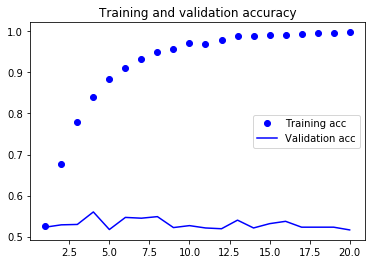

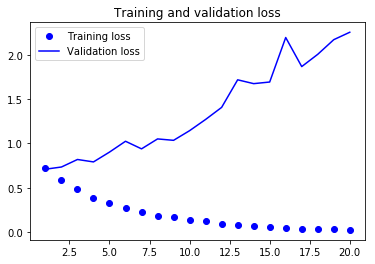

In [56]:
# 6.15: Plotting the results

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [57]:
# 6.16 Training the same model without pretrained word embeddings

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train, # 
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           700000    
_________________________________________________________________
flatten_5 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                160032    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 860,065
Trainable params: 860,065
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 1050 samples
Epoch 1/10
1000/1000 [==============================] - 1s 888us/step - loss: 0.6940 - acc: 0.5280 - val_loss: 0.6930 - val_acc: 0.5314
Epoch 2/10
1000/1000 [==============================] - 1s 508us/step - loss: 0.6437

In [59]:
# 6.17 Tokenizing the data of the test set

test_dir = os.path.join(group1_dir, 'test')
labels = []
texts = []
for label_type in ['male', 'female']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'male':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)            

# 6.18 Evaluating the model on the test set

model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

514/514 [==============================] - 0s 38us/step


[2.5486942200345286, 0.4961089494163424]

In [81]:
# 3.3: Model definition --NO EMBEDDINGS

from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(6745,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# 3.4: Compiling the model

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# 3.5: Configuring the optimizer 

from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 3.6: Using custom losses and metrics

from keras import losses
from keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

# 6.9: Tokenizing the text of the raw data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# FIX: maxlen size is the size of the set of independent/explanatory variables inputed in the NN

maxlen = 50 # Cuts off reviews after maxlen words.
training_samples = 1000 # Trains on taining_samples. 
validation_samples = 1050 # Validates on validation_samples. 
max_words = 6745 # Considers only the most frequent words in the dataset 
                 # group 1 dataset only has 6745 tokens. 

tokenizer = Tokenizer(num_words=max_words)  
tokenizer.fit_on_texts(texts) 
sequences = tokenizer.texts_to_sequences(texts) 
#print(sequences) # list of lists

print(texts[1])
one_hot_results = tokenizer.texts_to_matrix(texts, mode='binary')
print(len(one_hot_results[1])) 
               
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
#print(word_index)

data = one_hot_results 
print(data[1])

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices] # Splits the data into a training set and a validation set, but first shuffles the data, 
                         # because you’re starting with data in which samples are ordered (all negative first, 
                         # then all positive). 
        
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples] 
y_val = labels[training_samples: training_samples + validation_samples]


# 3.8: Training your model

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

No, nor I neither: I'll be at your elbow.
6745
Found 6745 unique tokens.
[0. 0. 0. ... 0. 0. 0.]
Shape of data tensor: (2050, 6745)
Shape of label tensor: (2050,)
Train on 1000 samples, validate on 1050 samples
Epoch 1/20
1000/1000 [==============================] - 1s 748us/step - loss: 0.6929 - acc: 0.5240 - val_loss: 0.6942 - val_acc: 0.5029
Epoch 2/20
1000/1000 [==============================] - 0s 99us/step - loss: 0.6764 - acc: 0.5800 - val_loss: 0.6953 - val_acc: 0.4943
Epoch 3/20
1000/1000 [==============================] - 0s 98us/step - loss: 0.6611 - acc: 0.6160 - val_loss: 0.6990 - val_acc: 0.4819
Epoch 4/20
1000/1000 [==============================] - 0s 99us/step - loss: 0.6448 - acc: 0.6270 - val_loss: 0.6961 - val_acc: 0.4971
Epoch 5/20
1000/1000 [==============================] - 0s 104us/step - loss: 0.6276 - acc: 0.7430 - val_loss: 0.7057 - val_acc: 0.4848
Epoch 6/20
1000/1000 [==============================] - 0s 106us/step - loss: 0.6106 - acc: 0.7260 - val_loss: 0

In [ ]:
# https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_text_classification.ipynb

In [15]:
print("Training entries: {}, labels: {}".format(len(x_train), len(y_train)))

Training entries: 2000, labels: 2000


In [16]:
print(x_train[4])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [17]:
len(x_train[0]), len(x_train[1])

(300, 300)